# Envs

In [2]:
"""
   Redo from DWF Python Example - Analog_Transistor.py
   Author:  Tran Le Phuong Lan
   Date:  2025-05-21

   Requires:                       
       Python 2.7, 3
"""

from ctypes import *

import math
import time
import sys
import os
from os import sep                # OS specific file path separators
import matplotlib.pyplot as plt
import numpy

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if sys.platform.startswith("win"):
    dwf = cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif sys.platform.startswith("darwin"): # on macOS
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else: # on Linux
    dwf = cdll.LoadLibrary("libdwf.so")
    constants_path = sep + "usr" + sep + "share" + sep + "digilent" + sep + "waveforms" + sep + "samples" + sep + "py"

# Import constans
sys.path.append(constants_path)
import dwfconstants as constants

# code from analog_transistor.py but 

**the physical setup is**

- 1. W1 - OSC1

- 2. W2 - OSC2

In [17]:
print("Configuring device...")
# collector: 0V to 5V triangle output and 50Hz, 20ms
dwf.FDwfAnalogOutEnableSet(hdwf, 0, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 0, constants.funcTriangle)
dwf.FDwfAnalogOutPhaseSet(hdwf, 0, c_double(270.0))
dwf.FDwfAnalogOutFrequencySet(hdwf, 0, c_double(50))
dwf.FDwfAnalogOutOffsetSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutMasterSet(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 0, 0)

# base: 1V to 2V in 5 steps at 10Hz, 100ms total length
dwf.FDwfAnalogOutEnableSet(hdwf, 1, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 1, constants.funcCustom)
dwf.FDwfAnalogOutFrequencySet(hdwf, 1, c_double(10))
dwf.FDwfAnalogOutOffsetSet(hdwf, 1, c_double(1.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 1, c_double(0.5))
# values normalized to +-1 
# ChatGPT: using Python's ctypes module to create a C-style array of 5 double values.
rgSteps = (c_double*5)(-1.0, -0.5, 0, 0.5, 1.0) 
# The output value will be Offset + Sample*Amplitude
# The Sample = values in rgSteps
dwf.FDwfAnalogOutDataSet(hdwf, 1, rgSteps, len(rgSteps))
dwf.FDwfAnalogOutRunSet(hdwf, 1, c_double(0.1))
dwf.FDwfAnalogOutRepeatSet(hdwf, 1, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 0)

# scope: 5000 samples at 50kHz, 100ms
dwf.FDwfAnalogInChannelEnableSet(hdwf, 0, 1)
dwf.FDwfAnalogInChannelEnableSet(hdwf, 1, 1)
dwf.FDwfAnalogInFrequencySet(hdwf, c_double(50e3))
dwf.FDwfAnalogInChannelRangeSet(hdwf, 0, c_double(10.0))
dwf.FDwfAnalogInChannelRangeSet(hdwf, 1, c_double(10.0))
dwf.FDwfAnalogInBufferSizeSet(hdwf, 5000)
dwf.FDwfAnalogInTriggerSourceSet(hdwf, constants.trigsrcAnalogOut2) 
dwf.FDwfAnalogInTriggerPositionSet(hdwf, c_double(0.05)) # 5ms, trigger at first sample
dwf.FDwfAnalogInConfigure(hdwf, 1, 0)

print("Wait for the offset to stabilize...")
time.sleep(1)

print("Starting test...")
dwf.FDwfAnalogInConfigure(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 1)

sts = c_int()
while True:
    dwf.FDwfAnalogInStatus(hdwf, 1, byref(sts))
    if sts.value == constants.DwfStateDone.value :
        break
    time.sleep(0.001)
print("done")

rgc1 = (c_double*5000)()
rgc2 = (c_double*5000)()
dwf.FDwfAnalogInStatusData(hdwf, 0, rgc1, len(rgc1)) # get channel 1 data
dwf.FDwfAnalogInStatusData(hdwf, 1, rgc2, len(rgc2)) # get channel 2 data


Configuring device...
Wait for the offset to stabilize...
Starting test...
done


1

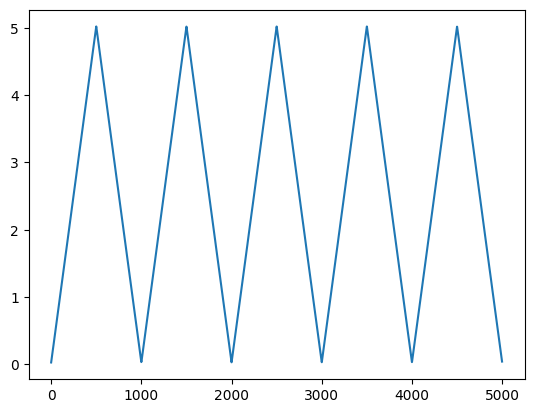

In [ ]:
plt.plot(numpy.arange(0, len(rgc1)), rgc1)

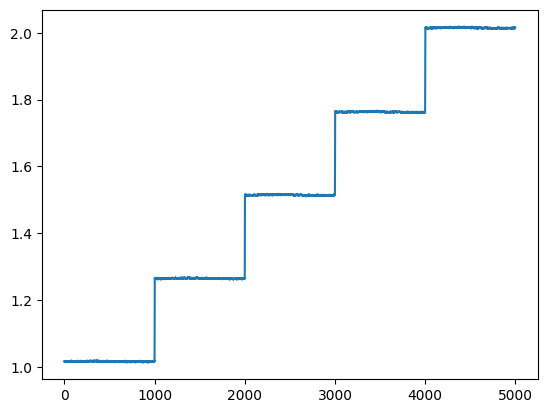

In [ ]:
plt.plot(numpy.arange(0, len(rgc2)), rgc2)

# Open the AD3

In [ ]:
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("Version: "+str(version.value))

cdevices = c_int()
dwf.FDwfEnum(0, byref(cdevices))
print("Number of Devices: "+str(cdevices.value))

if cdevices.value == 0:
    print("no device detected")
    quit()

dwf.FDwfParamSet(constants.DwfParamOnClose, 0) # 0 = run, 1 = stop, 2 = shutdown

print("Opening first device")
hdwf = c_int()

# ChatGPT:
# byref() is a function from the ctypes module in Python, 
# which is used to pass a reference to a variable rather than its value
dwf.FDwfDeviceOpen(-1, byref(hdwf))

if hdwf.value == constants.hdwfNone.value:
    print("failed to open device")
    quit()

Version: b'3.24.2'
Number of Devices: 1
Opening first device
failed to open device


: 

In [ ]:
dwf.FDwfDeviceAutoConfigureSet(hdwf, 0) # 0 = the device will only be configured when FDwf###Configure is called

# Physical setup

## EXP1


Comprises of

- 1. W1 - OSC1

- 2. W2 - OSC2

## EXP 2

Comprises of

- 1. W1 - OSC1

# App

## EXP 1

- Purpose:

  - 1. checkout status and configurations of oscilloscope channels and wave generator channels, after configuration, after running

  - 2. learning how the oscilloscope is configured to record all the signals generated from the wavge generator.

### Osc

#### Configure

In [3]:
# scope: 5000 samples at 50kHz, 100ms
dwf.FDwfAnalogInChannelEnableSet(hdwf, 0, 1)
dwf.FDwfAnalogInChannelEnableSet(hdwf, 1, 1)

dwf.FDwfAnalogInFrequencySet(hdwf, c_double(50e3))

dwf.FDwfAnalogInChannelRangeSet(hdwf, 0, c_double(10.0))
dwf.FDwfAnalogInChannelRangeSet(hdwf, 1, c_double(10.0))

dwf.FDwfAnalogInBufferSizeSet(hdwf, 5000)

dwf.FDwfAnalogInTriggerSourceSet(hdwf, constants.trigsrcAnalogOut2) 
dwf.FDwfAnalogInTriggerPositionSet(hdwf, c_double(0.05)) # 5ms, trigger at first sample

# (HDWF hdwf, int fReconfigure, int fStart)
dwf.FDwfAnalogInConfigure(hdwf, 1, 0)

print("Wait for the offset to stabilize...")
time.sleep(1)

Wait for the offset to stabilize...


#### Check osc configuration

In [5]:
# acquisition modes:
acq_mode_defs = {

        0: "acqmodeSingle",
        1: "acqmodeScanShift",
        2: "acqmodeScanScreen",
        3: "acqmodeRecord",
        4: "acqmodeOvers",
        5: "acqmodeSingle1"
}

In [8]:
# FDwfAnalogInAcquisitionModeGet(HDWF hdwf, ACQMODE *pacqmode)
acq_mode = c_int()
dwf.FDwfAnalogInAcquisitionModeGet(hdwf, byref(acq_mode))


1

In [ ]:
# convert c_int() to int python: a_cint = ctypes.c_int() -> a_int = a_cint.value
print(acq_mode_defs[acq_mode.value]) # by default, the acquisition mode is single

# "acqmodeSingle: Perform a single buffer acquisition and rearm the instrument for next capture after
# the data is fetched to host using FDwfAnalogInStatus or
# FDwfDigitalInStatus function. This is the default setting"

acqmodeSingle


In [ ]:
# FDwfAnalogInBufferSizeGet(HDWF hdwf, int *pnSize)
buf_size = c_int(0)
dwf.FDwfAnalogInBufferSizeGet(hdwf, byref(buf_size))
print(buf_size) # must return 5000 samples in the buffer bcz of the configuration above

c_int(5000)


### Wave Gen

#### configure wave gen

In [15]:
print("Configuring device...")

# collector: 0V to 5V triangle output and 50Hz, 20ms
# enable channel
# The following setup of FDwfAnalogOutNodeEnableSet is for normal use case of generating signal (i.e without modulation) 
#                         idxChannel AnalogOutNode   fMode
dwf.FDwfAnalogOutEnableSet(hdwf, 0, 1) 
# set function 
#                          idxChannel    AnalogOutNode func  
dwf.FDwfAnalogOutFunctionSet(hdwf, 0, constants.funcTriangle)
dwf.FDwfAnalogOutPhaseSet(hdwf, 0, c_double(270.0))
dwf.FDwfAnalogOutFrequencySet(hdwf, 0, c_double(50))
dwf.FDwfAnalogOutOffsetSet(hdwf, 0, c_double(2.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 0, c_double(2.5))
# FDwfAnalogOutMasterSet(HDWF hdwf, int idxChannel, int idxMaster)
dwf.FDwfAnalogOutMasterSet(hdwf, 0, 1)
# FDwfAnalogOutConfigure(HDWF hdwf, int idxChannel, int fStart)
# fStart: 0 stop, 1 start, 3 apply
dwf.FDwfAnalogOutConfigure(hdwf, 0, 0)

# base: 1V to 2V in 5 steps at 10Hz, 100ms total length
dwf.FDwfAnalogOutEnableSet(hdwf, 1, 1) 
dwf.FDwfAnalogOutFunctionSet(hdwf, 1, constants.funcCustom)
dwf.FDwfAnalogOutFrequencySet(hdwf, 1, c_double(10))
dwf.FDwfAnalogOutOffsetSet(hdwf, 1, c_double(1.5))
dwf.FDwfAnalogOutAmplitudeSet(hdwf, 1, c_double(0.5))
# values normalized to +-1 
rgSteps = (c_double*5)(-1.0, -0.5, 0, 0.5, 1.0)
dwf.FDwfAnalogOutDataSet(hdwf, 1, rgSteps, len(rgSteps))
dwf.FDwfAnalogOutRunSet(hdwf, 1, c_double(0.1)) # 0.1 second
# FDwfAnalogOutRepeatSet(HDWF hdwf, int idxChannel, int cRepeat)
dwf.FDwfAnalogOutRepeatSet(hdwf, 1, 1)
# FDwfAnalogOutConfigure(HDWF hdwf, int idxChannel, int fStart)
# fStart: 0 stop, 1 start, 3 apply
dwf.FDwfAnalogOutConfigure(hdwf, 1, 0)

Configuring device...


1

### Run and record

In [16]:
print("Starting test...")
dwf.FDwfAnalogInConfigure(hdwf, 0, 1)
dwf.FDwfAnalogOutConfigure(hdwf, 1, 1)

sts = c_int()
while True:
    dwf.FDwfAnalogInStatus(hdwf, 1, byref(sts))
    if sts.value == constants.DwfStateDone.value :
        break
    time.sleep(0.001)
print("done")

rgc1 = (c_double*5000)()
rgc2 = (c_double*5000)()
dwf.FDwfAnalogInStatusData(hdwf, 0, rgc1, len(rgc1)) # get channel 1 data
dwf.FDwfAnalogInStatusData(hdwf, 1, rgc2, len(rgc2)) # get channel 2 data

Starting test...
done


1

#### Instrument states after running, and collecting the recorded data

In [24]:
# instrument states
instr_state_defs = {
    0: "DwfStateReady",
    4: "DwfStateConfig",
    5: "DwfStatePrefill",
    1: "DwfStateArmed",
    7: "DwfStateWait",
    3: "DwfStateTriggered",
    3: "DwfStateRunning",
    6: "DwfStateNotDone",
    2: "DwfStateDone"
}

# check instrument status

## Oscilloscope
dwf.FDwfAnalogInStatus(hdwf, 1, byref(sts))
print(f"status of the osc ch 1 after collecting the recorded data: {instr_state_defs[sts.value]}")

dwf.FDwfAnalogInStatus(hdwf, 0, byref(sts))
print(f"status of the osc ch 0 after collecting the recorded data: {instr_state_defs[sts.value]}")

# FDwfAnalogOutStatus(HDWF hdwf, int idxChannel, DwfState *psts)
dwf.FDwfAnalogOutStatus(hdwf, 0, byref(sts))
print(f"status of the wg ch 0 after collecting the recorded data: {instr_state_defs[sts.value]}")
dwf.FDwfAnalogOutStatus(hdwf, 1, byref(sts))
print(f"status of the wg ch 1 after collecting the recorded data: {instr_state_defs[sts.value]}")

status of the osc ch 1 after collecting the recorded data: DwfStateArmed
status of the osc ch 0 after collecting the recorded data: DwfStateArmed
status of the wg ch 0 after collecting the recorded data: DwfStateDone
status of the wg ch 1 after collecting the recorded data: DwfStateDone


#### Plot the recorded data

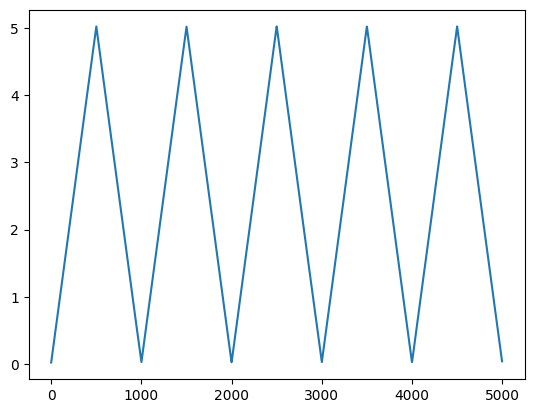

In [17]:
plt.plot(numpy.arange(0, len(rgc1)), rgc1)

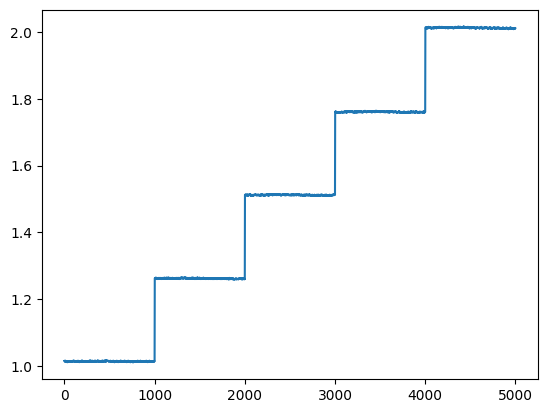

In [18]:
plt.plot(numpy.arange(0, len(rgc2)), rgc2)

## EXP 2

- **REFERENCE**

[1] [online WaveForms app manual](https://digilent.com/reference/software/waveforms/waveforms-3/reference-manual?s[]=waveform&s[]=app&s[]=manual)

- Purpose: continuously reading in value from the wavegenerator using a oscilloscope

  - To check out the configuration of wavegenerator when it is in idle states (Waiting, Ready, Stopped, or Done states).

  - Set the oscilloscope in single acquisition, 
    
    - could the two oscilloscope channel be independent with different Trigger configure? (My current guess is not, because we could not set the channel with the function: FDwfAnalogInTriggerSourceSet. -> we could test it out!)

    - According to WaveForms SDK Reference Manual, the by default, Trigger source is None. According to WaveForms manual (app), Trigger source None = the acquisition is started without a trigger. 

    - In the starting guide (https://digilent.com/reference/test-and-measurement/analog-discovery-3/getting-started), the Trigger is Auto. According to reference [1], the Trigger Auto = "when the trigger condition does not appear in 2 seconds, the acquisition is started automatically. **In repeated acquisition mode**, when the **instrument switches to auto trigger**, the **next acquisitions are made without waiting again to timeout while a trigger event does not occur** and the **configuration is not changed**. **When a new trigger event occurs, or the configuration is changed**, the **current acquisition will be finished** and the **next one will wait for the trigger again**. It is also the best mode to use if you are looking at many signals and do not want to bother setting the trigger each time"

    - acqmodeScanScreen, acqmodeScanShift: ignore Trigger.

    -  acqmodeScanShift (see example `../WaveSDK_examples/AnalogIn_ShiftScreen.py`): FIFO

    - acqmodeScanScreen : similar to a heart monitor display 

    - acqmodeRecord: stream data to host (?) is it like streaming options in WaveForms app manual reference (see `../README.md` - Reference - [8]) (see example `../WaveSDK_examples/AnalogIn_Record.py`). 

    - Maybe, using multi-thread programming technique in python to setup 1 thread for modifying the wavegenerator, another thread for recording the wave + save the recorded into file. The recording can use acqmodeScanShift (see example `../WaveSDK_examples/AnalogIn_ShiftScreen.py`) as an example. (? What is the difference between acqmodeScanShift, acqmodeRecord -> scanshift ignores trigger, while record still follows the trigger)


# Close AD3

In [4]:
dwf.FDwfDeviceCloseAll()

1